# HNSW

Hierarchical Navigable Small World，分层可导航小世界

是一种基于图结构的近似最近邻（ANN）搜索算法

## 核心思想

先在高层图中快速找到大致方向，再在底层图中精确定位目标。




In [29]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time
from collections import defaultdict

In [30]:
# 强制设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可重现
np.random.seed(41)


In [31]:
class SimpleHNSW:
    '''
    HSNW 索引的简化实现
    '''

    def __init__(self, max_elements=1000, M=10, ef_construction=50, max_layers=6) -> None:
        '''
        初始化HNSW索引

        参数
        - max_elements: 最大元素数量
        - M: 每个节点的最大连接数
        - ef_construction: 构建时的搜索范围
        - max_layers: 最大层数
        '''
        self.max_elements = max_elements
        self.M = M 
        self.ef_confstruction = ef_construction
        self.max_layers = max_layers

        # 存储所有数据点
        self.data_points = []  # point_id -> vector
        # 每层的图结构（领接表）
        # 图是一个dict, key: 节点id; value:是邻居列表
        self.layers = [defaultdict(list) for _ in range(max_layers)]

        # 全局入口点（最高层节点）
        self.entry_point = None
        self.entry_level = -1 # 入口点所在的最高层级

    def _random_level(self):
        '''
        随机生成节点的层级（指数分布）
        '''
        level = 0
        while random.random() < 0.5 and level < self.max_layers - 1:
            level += 1
        return level

    def _euclidean_distance(self, a, b):
        ''' 计算欧氏距离 '''
        return np.sqrt(np.sum((a - b) ** 2))

    def _search_layer(self, query, entry_point, ef, layer):
        '''
        在指定层搜索最近邻
        
        参数:
        - query: 查询向量
        - entry_point: 搜索的起始点
        - ef: 搜索范围（返回的候选点数量）
        - layer: 搜索的层级
        '''
        if entry_point is None or entry_point not in self.layers[layer]:
            return []
        
        visited = set([entry_point])

        # 候选集: 保存（距离，节点ID）元组，从入口开始
        candidates = [(self._euclidean_distance(query, self.data_points[entry_point]), entry_point)]
        # 使用堆来维护候选集 TODO:这里使用列表排序
        results = []

        while candidates and len(results) < ef:
            # 获取距离最近的candidate
            candidates.sort(key=lambda x:x[0])      # 按照距离排序
            current_dist, current_point = candidates.pop(0)

            # 检查是否应该将当前点加入结果
            if not results or current_dist < results[-1][0]:
                results.append((current_dist, current_point))
                results.sort(key=lambda x:x[0])
                if len(results) > ef:
                    results = results[:ef]

            # 探索当前点的所有邻居节点
            for neighbor in self.layers[layer][current_point]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    dist = self._euclidean_distance(query, self.data_points[neighbor])
                    candidates.append((dist, neighbor))
            
        return results

    def add_point(self, point):
        '''
        向HNSW中添加新节点

        参数:
        - point: 要添加的数据点向量
        ''' 
        if len(self.data_points) >= self.max_elements:
            raise ValueError('too many elements')
        
        point_id = len(self.data_points)
        self.data_points.append(point)

        # 确定新节点的层级
        level = self._random_level()

        # 如果是第一个点，设为入口点
        if self.entry_point is None:
            self.entry_point = point_id
            self.entry_level = level
            for l in range(level+1):
                self.layers[l][point_id] = [] # 在新点的每一层创建空邻居列表
            return 
        
        # 从最高层开始搜索，找到每层的入口点
        current_point = self.entry_point
        current_max_level = self.entry_level

        # 从顶层开始搜索，找到到每层的入口点
        for l in range(current_max_level, level, -1):
            if l < len(self.layers):
                results = self._search_layer(point, current_point, 1, l)
                if results:
                    current_point = results[0][1] # 更新为更近的点

        # 从新节点的最高层开始，逐层向下插入并建立连接
        for l in range(min(current_max_level, level), -1, -1):
            # 在当前层搜索ef_construction个最近领
            results = self._search_layer(point, current_point, self.ef_confstruction, l)

            # 选择前M个最近领作为连接
            neighbors = [idx for _, idx in results[:self.M]] 

            # 在新节点的当前层创建连接
            self.layers[l][point_id] = neighbors.copy()

            # 双向连接：邻居也要连接到新节点
            for neighbor in neighbors:
                if len(self.layers[l][neighbor]) < self.M:
                    # 邻居连接数未满，直接添加
                    self.layers[l][neighbor].append(point_id)
                else:
                    # 如果邻居连接数已满，替换最远的连接
                    neighbor_neighbors = self.layers[l][neighbor]
                    distances = [self._euclidean_distance(
                        self.data_points[neighbor], self.data_points[n]) 
                        for n in neighbor_neighbors
                    ]
                    max_idx = np.argmax(distances) # 找到最远的邻居
                    # 如果新点更近，则替换最远的邻居
                    if self._euclidean_distance(self.data_points[neighbor], point) < distances[max_idx]:
                        neighbor_neighbors[max_idx] = point_id

        # 如果新节点的层级比当前入口点更高，更新entry_point和entry_level
        if level > self.entry_level:
            self.entry_point = point_id
            self.entry_level = level
        
    def search(self, query, k=5, ef_search=50):
        '''
        在HNSW中搜索最近邻

        参数:
        - query: 查询向量
        - k: 返回的最近邻数量
        - ef_search: 搜索时的候选集大小（越大精度越高但速度越慢）

        返回:
        - List<节点Id,距离> 按照距离从近到远排序
        '''
        if self.entry_point is None:
            return []
        
        current_point = self.entry_point
        current_level = self.entry_level

        # 从顶层开始搜索
        for l in range(current_level, 0, -1):
            results = self._search_layer(query, current_point, 1, l)
            if results:
                current_point = results[0][1] # 更新为每层的入口点

        # 在最底层进行精细搜索
        results = self._search_layer(query, current_point, ef_search, 0)

        # 返回前k个结果
        return [(idx, dist) for dist, idx in results[:k]]

    def _search_layer_with_path(self, query, entry_point, ef, layer, path_nodes):
        '''
        在指定层搜索最近邻，并记录搜索路径

        参数:
        - query: 查询向量
        - entry_point: 搜索起始点
        - ef: 搜索范围
        - layer: 搜索的层级
        - path_nodes: 用于记录搜索路径的列表
        
        返回:
        - 搜索结果列表
        '''
        if entry_point is None or entry_point not in self.layers[layer]:
            return []

        visited = set([entry_point])
        candidates = [(self._euclidean_distance(query, self.data_points[entry_point]), entry_point)]
        results = []
        
        while candidates and len(results) < ef:
            candidates.sort(key=lambda x:x[0]) # 根据距离排序
            current_dist, current_point = candidates.pop(0)

            # 记录访问的节点到路径中
            if current_point not in path_nodes:
                path_nodes.append(current_point)

            if not results or current_dist < results[-1][0]:
                results.append((current_dist, current_point))
                results.sort(key=lambda x:x[0])
                if len(results) > ef:
                    results = results[:ef]
            
            # 探索邻居节点
            for neighbor in self.layers[layer][current_point]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    dist = self._euclidean_distance(query, self.data_points[neighbor])
                    candidates.append((dist, neighbor))

            return results

    def search_with_path(self, query, k=5, ef_search=50):
        '''
        搜索最近邻，并记录搜索路径

        参数:
        - query: 查询向量
        - k: 返回的最近邻向量数量
        - ef_search: 搜索时的候选集大小

        返回:
        - results: List<节点ID, 距离>
        - search_path: 每层的搜索路径
        '''
        if self.entry_point is None:
            return [], {}
        
        current_point = self.entry_point
        current_level = self.entry_level
        search_path = {}

        # 从顶层开始搜索, 并记录路径
        for l in range(current_level, 0, -1):
            path_nodes = [current_point]
            results = self._search_layer_with_path(query, current_point, 1, l, path_nodes)
            search_path[l] = path_nodes
            if results:
                current_point = results[0][1]
        
        # 在最底层进行精细搜索
        path_nodes = [current_point]
        results = self._search_layer_with_path(query, current_point, ef_search, 0, path_nodes)
        search_path[0] = path_nodes

        # 返回前k个结果和搜索路径
        final_results = [(idx, dist) for dist, idx in results[:k]]
        return final_results, search_path

In [32]:
# 生成示例数据和可视化函数

def generate_sample_data(n_samples=200, dim=2):
    '''生成示例数据：4个分离的高斯分布Cluster'''

    cluster1 = np.random.normal(loc=[2,2], scale=0.3, size=(n_samples//4, dim))
    cluster2 = np.random.normal(loc=[8,3], scale=0.4, size=(n_samples//4, dim))
    cluster3 = np.random.normal(loc=[5,8], scale=0.35, size=(n_samples//4, dim))
    cluster4 = np.random.normal(loc=[3,6], scale=0.4, size=(n_samples - 3 * (n_samples//4), dim))

    data = np.vstack([cluster1, cluster2, cluster3, cluster4])
    return data

In [33]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 可视化
def _sort_legend(ax):
    """自动去重并保持绘图顺序"""
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)

def _draw_3d_base(ax, hnsw, data, layers, h_gap, query=None):
    """3D视图通用底座"""
    z_max = (max(layers) * h_gap) + 2.0 if layers else 10
    ax.set_axis_off()
    ax.view_init(elev=20, azim=-60)
    ax.set_zlim(0, z_max)
    
    x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
    y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
    
    # 简单的颜色列表，用于区分层级
    layer_colors = ['#FFFACD', '#98FB98', '#87CEEB', '#DDA0DD', '#F0E68C']
    
    for l in layers:
        z = l * h_gap
        color = layer_colors[l % len(layer_colors)]
        # 平面
        corners = [[x_min, y_min, z], [x_max, y_min, z], [x_max, y_max, z], [x_min, y_max, z]]
        poly = Poly3DCollection([corners], alpha=0.1, facecolor=color)
        ax.add_collection3d(poly)
        # 边框
        for i in range(4):
            ax.plot([corners[i][0], corners[(i+1)%4][0]], [corners[i][1], corners[(i+1)%4][1]], [z, z], 'k-', alpha=0.15, lw=0.8)
        ax.text(x_min, y_min, z, f'Layer {l}', fontsize=9, fontweight='bold', ha='right')
        # 节点
        nodes = list(hnsw.layers[l].keys())
        if nodes:
            pts = data[nodes]
            ax.scatter(pts[:, 0], pts[:, 1], z, c='#888888', s=20, alpha=0.3, edgecolors='none', label='数据点')
        # 查询点投影
        if query is not None:
            ax.scatter(query[0], query[1], z, c='#FFD93D', marker='*', s=100, alpha=0.3, label=None)



In [34]:
# --- 分步绘图函数 ---

def _plot_step_1(ax, data, query):
    """步骤1：绘制原始数据分布"""
    ax.scatter(data[:, 0], data[:, 1], c='lightblue', alpha=0.6, s=30, label='数据点')
    if query is not None: ax.scatter(query[0], query[1], c='#FFD93D', marker='*', s=200, edgecolors='black', label='查询点')
    ax.set_title('1. 原始数据分布'); ax.grid(True, alpha=0.3)

def _plot_step_2(ax, hnsw, data, layers, h_gap, node_levels):
    """步骤2：展示构图逻辑（随机定层 & 邻居连接）"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap)
    target = next((n for n, ls in node_levels.items() if len(ls) >= 2), list(node_levels.keys())[0])
    levels = node_levels.get(target, [])
    for l in layers:
        if l in levels:
            z = l * h_gap
            pt = data[target]
            ax.scatter(pt[0], pt[1], z, c='red', s=100, edgecolors='black', zorder=10, label='新节点')
            nbs = hnsw.layers[l].get(target, [])
            if nbs:
                nb_pts = data[nbs]
                ax.scatter(nb_pts[:, 0], nb_pts[:, 1], z, c='green', s=60, edgecolors='black', zorder=9, label='邻居节点')
                for nb in nb_pts: ax.plot([pt[0], nb[0]], [pt[1], nb[1]], [z, z], c='purple', linewidth=2, zorder=8, label='建立连接')
    ax.set_title('2. 构图逻辑: 随机定层 & 邻居连接')

def _plot_step_3(ax, hnsw, data, layers, h_gap, node_levels):
    """步骤3：HNSW 多层结构概览"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap)
    layer_colors = ['#FFFACD', '#98FB98', '#87CEEB', '#DDA0DD', '#F0E68C']
    for l in layers:
        z = l * h_gap
        nodes = list(hnsw.layers[l].keys())
        if nodes:
            color = layer_colors[l % len(layer_colors)]
            ax.scatter(data[nodes, 0], data[nodes, 1], z, c=[color], edgecolors='black', s=40, alpha=0.8)
            for n in nodes[:20]:
                for nb in hnsw.layers[l][n]:
                    ax.plot([data[n][0], data[nb][0]], [data[n][1], data[nb][1]], [z, z], c='gray', alpha=0.2, lw=0.5)
    for n, ls in list(node_levels.items())[:30]:
        if len(ls) > 1:
            pt = data[n]
            ax.plot([pt[0], pt[0]], [pt[1], pt[1]], [min(ls)*h_gap, max(ls)*h_gap], 'k--', alpha=0.2, lw=0.5, label='跨层连接')
    ax.set_title('3. HNSW 多层结构概览')

def _plot_step_4(ax, hnsw, layers, path):
    """步骤4：分析结构规模与搜索代价"""
    counts = [len(hnsw.layers[l]) for l in layers]
    costs = [0] * len(layers)
    if path:
        for l, p in path.items():
            if l in layers: costs[layers.index(l)] = len(p)
    ax.bar(layers, counts, color='skyblue', alpha=0.6, label='层级节点总数')
    ax2 = ax.twinx()
    ax2.plot(layers, costs, 'r-o', lw=2, label='实际访问节点数')
    ax.set_title('4. 结构规模 vs 搜索代价'); ax.set_xlabel('Layer')
    lines, labels = ax.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax.legend(lines+l2, labels+lb2, loc='upper right')

def _plot_step_5(ax, hnsw, data, layers, h_gap, query):
    """步骤5：展示顶层入口点选择"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap, query)
    z_top = max(layers) * h_gap
    entry = data[hnsw.entry_point]
    if query is not None:
        ax.scatter(query[0], query[1], z_top+1.5, c='#FFD93D', marker='*', s=300, edgecolors='black', zorder=20, label='查询点')
        ax.plot([query[0], query[0]], [query[1], query[1]], [0, z_top+1.5], 'k--', alpha=0.2)
        ax.plot([query[0], entry[0]], [query[1], entry[1]], [z_top, z_top], c='orange', ls='--', label='距离指示')
    ax.scatter(entry[0], entry[1], z_top, c='red', marker='v', edgecolors='black', s=200, zorder=20, label='入口点')
    ax.scatter(entry[0], entry[1], z_top, c='red', s=600, alpha=0.2)
    ax.set_title('5. 入口点选择 (Top Layer)')

def _plot_step_6(ax, hnsw, data, layers, h_gap, query, path):
    """步骤6：演示下潜检索过程"""
    _draw_3d_base(ax, hnsw, data, layers, h_gap, query)
    if path and query is not None:
        ax.scatter(query[0], query[1], 0, c='#FFD93D', marker='*', s=0, alpha=0, label='查询点') # Legend hack
        for l, p in path.items():
            z = l * h_gap
            pts = data[p]
            ax.plot(pts[:,0], pts[:,1], [z]*len(pts), c='red', lw=2 if l>0 else 1, label='搜索路径')
            ax.scatter(pts[:,0], pts[:,1], z, c='orange', s=50, edgecolors='black', label='访问节点')
            for n in p[:3]:
                for nb in hnsw.layers[l][n]:
                    nb_pt = data[nb]
                    ax.plot([data[n][0], nb_pt[0]], [data[n][1], nb_pt[1]], [z, z], c='purple', alpha=0.2, label='考察连线')
            if l > 0 and (l-1) in path:
                prev = data[path[l-1][0]]
                ax.plot([pts[-1,0], prev[0]], [pts[-1,1], prev[1]], [z, z-h_gap], c='blue', ls='--', label='层间下潜')
    ax.set_title('6. 下潜检索过程')


def _plot_step_7(ax, hnsw, data, query, path, results, ef=20):
    """步骤7：底层精确搜索 (Layer 0)"""
    l0_nodes = list(hnsw.layers[0].keys())
    ax.scatter(data[l0_nodes, 0], data[l0_nodes, 1], c='#ecf0f1', s=30, label='数据点')
    if path and 0 in path:
        p = path[0]; p_pts = data[p]
        inspected = {nb for n in p for nb in hnsw.layers[0][n]} - set(p)
        if inspected:
            ins_pts = data[list(inspected)]
            ax.scatter(ins_pts[:, 0], ins_pts[:, 1], c='#9b59b6', s=40, alpha=0.5, label='候选邻居')
        for i in range(len(p_pts)-1):
            ax.arrow(p_pts[i,0], p_pts[i,1], p_pts[i+1,0]-p_pts[i,0], p_pts[i+1,1]-p_pts[i,1],
                     head_width=0.2, fc='#e67e22', ec='#e67e22', length_includes_head=True, zorder=5)
        ax.scatter(p_pts[:,0], p_pts[:,1], c='#e67e22', s=60, edgecolors='black', label='移动轨迹', zorder=6)
        ax.scatter(p_pts[0,0], p_pts[0,1], c='red', marker='v', edgecolors='black', s=150, label='Layer 0 入口', zorder=10)
    if query is not None: ax.scatter(query[0], query[1], c='#FFD93D', marker='*', edgecolors='black', s=350, label='查询点')
    if results:
        res_pts = data[[r[0] for r in results]]
        ax.scatter(res_pts[:, 0], res_pts[:, 1], c='red', s=100, marker='o', alpha=0.8, label='HNSW结果')
    ax.set_title(f'7. 底层精搜 (ef={ef})')

def _plot_step_8(ax, data, query, results):
    """步骤8：结果对比与召回率分析"""
    if not results or query is None: return
    k = len(results)
    dists = euclidean_distances([query], data)[0]
    gt_idx = np.argsort(dists)[:k]
    recall = len(set(gt_idx) & set([r[0] for r in results])) / k
    ax.scatter(data[:, 0], data[:, 1], c='lightgray', s=30, alpha=0.3, label='数据点')
    ax.scatter(data[gt_idx, 0], data[gt_idx, 1], edgecolors='green', facecolors='none', linewidth=2.5, marker='s', label='暴力搜索 (GT)')
    res_pts = data[[r[0] for r in results]]
    ax.scatter(res_pts[:, 0], res_pts[:, 1], c='red', s=100, marker='o', alpha=0.8, label='HNSW结果')
    ax.scatter(query[0], query[1], c='#FFD93D', marker='*', edgecolors='black', s=300, label='查询点')
    missed = set(gt_idx) - set([r[0] for r in results])
    for idx in missed:
        pt = data[idx]
        ax.plot([query[0], pt[0]], [query[1], pt[1]], c='red', ls='--', alpha=0.6)
        ax.text(pt[0], pt[1], "漏检", color='red', fontweight='bold')
    ax.set_title(f'8. 结果对比 (召回率: {recall:.1%})')

def visualize_hnsw(hnsw, query_point=None, results=None, search_path=None):
    """简化后的可视化入口函数"""
    if not hnsw.data_points: return
    data = np.array(hnsw.data_points)
    layers = sorted([l for l in range(hnsw.max_layers) if hnsw.layers[l]])
    node_levels = {}
    for l in layers:
        for n in hnsw.layers[l]: node_levels.setdefault(n, []).append(l)
    h_gap = 2.0
    
    fig = plt.figure(figsize=(24, 12))
    layout = [(1, False), (2, True), (3, True), (4, False), (5, True), (6, True), (7, False), (8, False)]
    axes = [fig.add_subplot(2, 4, i, projection='3d' if is3d else None) for i, is3d in layout]
    
    _plot_step_1(axes[0], data, query_point)
    _plot_step_2(axes[1], hnsw, data, layers, h_gap, node_levels)
    _plot_step_3(axes[2], hnsw, data, layers, h_gap, node_levels)
    _plot_step_4(axes[3], hnsw, layers, search_path)
    _plot_step_5(axes[4], hnsw, data, layers, h_gap, query_point)
    _plot_step_6(axes[5], hnsw, data, layers, h_gap, query_point, search_path)
    _plot_step_7(axes[6], hnsw, data, query_point, search_path, results)
    _plot_step_8(axes[7], data, query_point, results)
    
    for ax in axes: _sort_legend(ax)
    plt.tight_layout(); plt.show()



In [35]:
from sklearn.metrics.pairwise import euclidean_distances

def demonstrate_hnsw_performance():
    """演示HNSW性能对比"""
    print("=" * 60)
    print("HNSW算法性能演示")
    print("=" * 60)
    
    # 生成测试数据
    data = generate_sample_data(500, 2)
    print(f"生成{len(data)}个二维数据点")
    
    # 创建HNSW索引
    hnsw = SimpleHNSW(max_elements=1000, M=10, ef_construction=50, max_layers=5)
    
    # 批量添加数据
    print("构建HNSW索引...")
    start_time = time.time()
    for i, point in enumerate(data):
        hnsw.add_point(point)
        if (i + 1) % 100 == 0:
            print(f"已添加{i + 1}个点")

    construction_time = time.time() - start_time
    print(f"HNSW索引构建完成，耗时: {construction_time:.4f}秒")
    
    # 选择查询点
    query_point = np.array([5.0, 5.0])
    print(f"\n查询点: {query_point}")
    
    # 使用HNSW搜索
    start_time = time.time()
    hnsw_results, search_path = hnsw.search_with_path(query_point, k=5, ef_search=30)
    hnsw_time = time.time() - start_time
    
    # 暴力搜索作为基准
    start_time = time.time()
    distances = euclidean_distances([query_point], data)[0]
    bf_indices = np.argsort(distances)[:5]
    bf_distances = distances[bf_indices]
    bf_time = time.time() - start_time

    # 显示结果对比
    print(f"\n搜索结果对比:")
    print(f"HNSW搜索 - 找到{len(hnsw_results)}个最近邻, 耗时: {hnsw_time:.6f}秒")
    print(f"暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒")
    
    print(f"\n速度提升: {bf_time/hnsw_time:.2f}倍")
    
    print(f"\nHNSW结果索引: {[idx for idx, _ in hnsw_results]}")
    print(f"HNSW结果距离: {[dist for _, dist in hnsw_results]}")
    print(f"暴力搜索结果索引: {bf_indices}")
    print(f"暴力搜索结果距离: {bf_distances}")
    
    # 检查召回率
    hnsw_indices_set = set(idx for idx, _ in hnsw_results)
    bf_indices_set = set(bf_indices)
    intersection = hnsw_indices_set & bf_indices_set
    recall = len(intersection) / len(bf_indices_set)
    print(f"召回率: {recall:.2%} ({len(intersection)}/{len(bf_indices_set)})")
    
    return hnsw, data, query_point, hnsw_results, bf_indices, search_path

HNSW算法性能演示
生成500个二维数据点
构建HNSW索引...
已添加100个点
已添加200个点
已添加300个点
已添加400个点
已添加500个点
HNSW索引构建完成，耗时: 1.6514秒

查询点: [5. 5.]

搜索结果对比:
HNSW搜索 - 找到1个最近邻, 耗时: 0.000589秒
暴力搜索 - 找到5个最近邻, 耗时: 0.001845秒

速度提升: 3.13倍

HNSW结果索引: [6]
HNSW结果距离: [np.float64(4.41603535724494)]
暴力搜索结果索引: [413 388 432 455 469]
暴力搜索结果距离: [1.22349405 1.41514852 1.46875599 1.47425948 1.51560546]
召回率: 0.00% (0/5)


/tmp/ipython-input-1529835356.py:157: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1529835356.py:157: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1529835356.py:157: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1529835356.py:157: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1529835356.py:157: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-1529835356.py:157: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-152

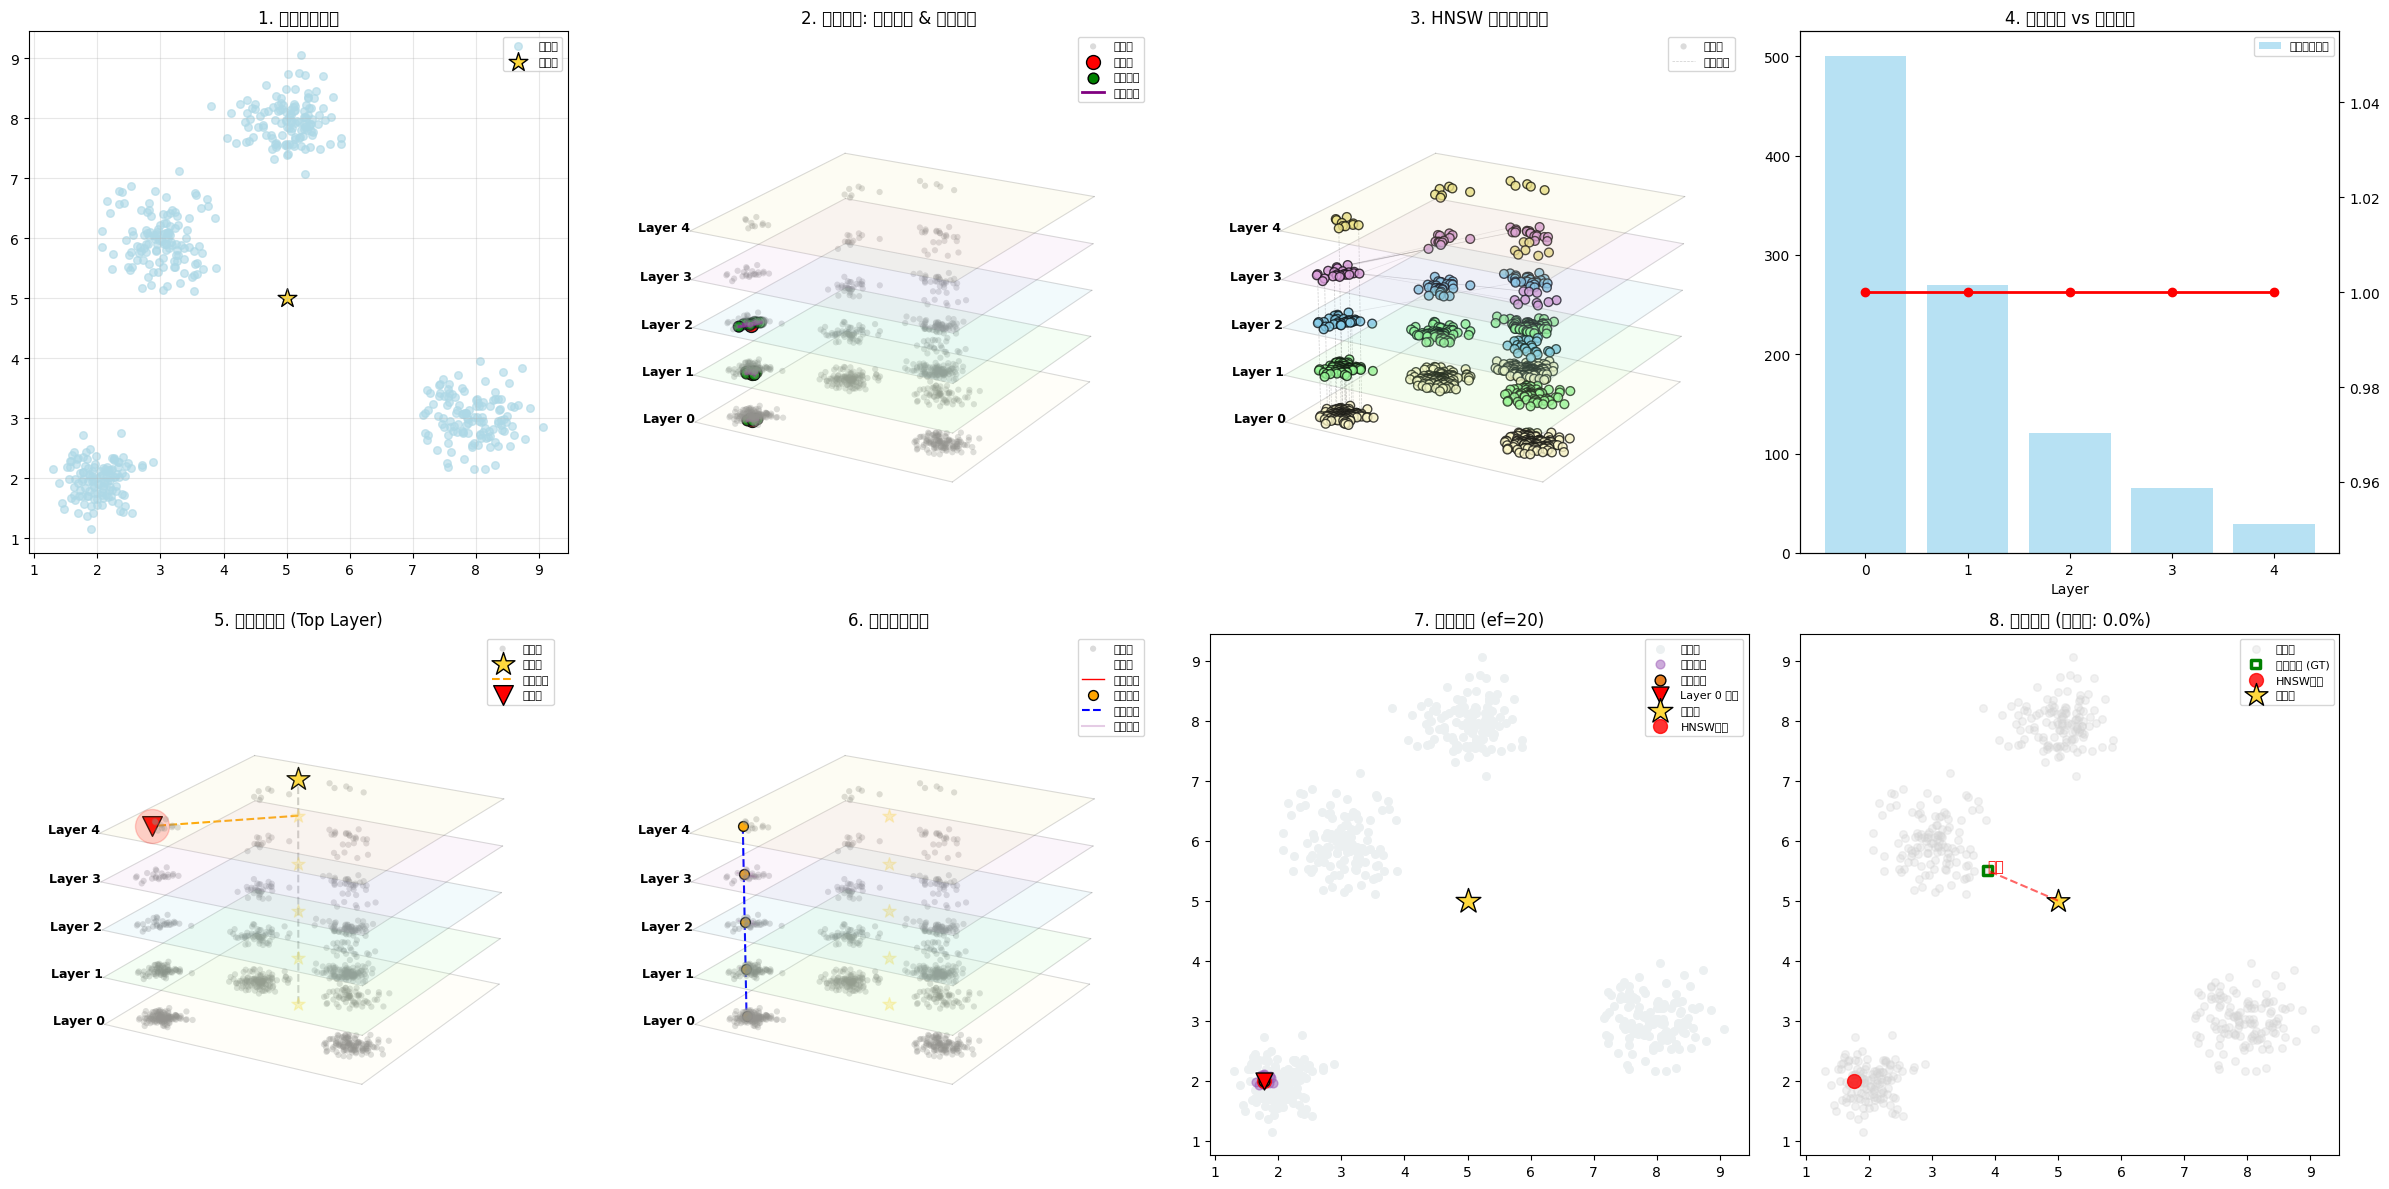

In [36]:
# 1. 运行标准演示
hnsw, data, query, hnsw_results, bf_results, search_path = demonstrate_hnsw_performance()

# 2. 调用可视化
visualize_hnsw(hnsw, query, hnsw_results, search_path)

# 参数分析

## M(最大连接数)
决定了图中每个节点可以和多少个邻居建立连接。M值越大，图的连通性越好，导航路径越多，但也会使索引更复杂、更占内存

## ef_construction（构建时候选集大小）
控制着在插入一个新节点时，算法会在每一层探索多少个候选邻居来寻找最佳连接。此值越大，构建出的图质量通常越高，搜索精度越有保障，但索引的构建时间也会相应增加